In [1]:
import numpy as np 
import pandas as pd 
import xgboost as xgb

# Import classifiers
from xgboost.sklearn import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Import environments and plotting libraries
import os
import getpass
import sklearn
import seaborn as sns
import matplotlib.pylab as plt

# Import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, r2_score, confusion_matrix, auc
from sklearn.metrics import precision_recall_curve, auc, average_precision_score

# Import synthetic data methods
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN

# Save models
import dill as pickle

In [2]:
% matplotlib inline

### Import Data

In [3]:
# Import Data
DATA_DIR ='/Users/{}/Dropbox/VirtualBeach/Regression'.format(getpass.getuser())
train_eval_test_1 = pd.read_csv(os.path.join(DATA_DIR, 'Woodlawn_Jundong_2008-2016.csv'), header='infer', sep=',', index_col=0)
train_eval_test_1.reindex(range(len(train_eval_test_1)))

train_eval_test_2 = pd.read_csv(os.path.join(DATA_DIR, 'Woodlawn_Jundong_2017.csv'), header='infer', sep=',', index_col=0)
train_eval_test_2.reindex(range(len(train_eval_test_2)))

train_eval_test_3 = pd.read_csv(os.path.join(DATA_DIR, 'Woodlawn_Jundong_2018.csv'), header='infer', sep=',', index_col=0)
train_eval_test_3.reindex(range(len(train_eval_test_3)))

train_eval_test = pd.concat([train_eval_test_1, train_eval_test_2, train_eval_test_3], axis=0, ignore_index=True)

In [4]:
train_eval_test.shape

(617, 45)

In [5]:
train_eval_test.tail()

,Date,LOG10,Stream_Ght_ft,Stream_Ght_PreDay,Stream_Turb_NTU,Stream_Turb_PreDay,WaveHt_Ft,Lake_Turb_NTU,Lake_Temp_C,Air_Temp_C,...,EvWater_24hr,NvWater_24hr,Angle_v_24hr,Magnitude_24hr,Parallel_Current_24hr,Parallel_WaveHt_24hr,Parallel_WaveDir_24hr,Perp_Current_24hr,Perp_WaveHt_24hr,Perp_WaveDir_24hr
612,7/13/18,1.778151,2.20,0.11,22.75,-5.10,1.0,2.160,22.0,18.0,...,0.024549,-0.017854,116.501322,0.042278,0.017854,-0.097447,-0.570990,-0.024549,-0.139557,-0.668144
613,7/14/18,2.255273,2.54,0.34,20.40,-2.35,5.0,9.280,23.0,23.0,...,0.053858,0.048752,45.729603,0.075012,-0.048752,-0.143519,-0.720212,-0.053858,-0.120619,-0.574959
614,7/15/18,2.146128,2.18,-0.36,22.55,2.15,3.0,5.745,23.0,21.0,...,0.063154,0.072350,41.589786,0.097703,-0.072350,-0.171731,-0.573789,-0.063154,-0.242339,-0.799676
615,7/16/18,1.954243,2.28,0.10,20.75,-1.80,3.0,1.635,24.0,23.5,...,0.045643,0.019391,69.362638,0.061810,-0.019391,-0.080237,-0.451652,-0.045643,-0.155713,-0.861745
616,7/17/18,2.623249,2.34,0.06,23.45,2.70,6.0,21.750,24.5,22.5,...,0.065574,0.070023,43.158814,0.096663,-0.070023,-0.173710,-0.618994,-0.065574,-0.235451,-0.750616


In [6]:
# Binarlie the problem
ecoli_threshold = 235.
X = train_eval_test.iloc[:,2:].copy()
y = train_eval_test.iloc[:,1].copy().apply(lambda x: 1 if x>=np.log10(ecoli_threshold) else 0)

# Set random seed
rand_seed = 456
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state=rand_seed)
# X_train , X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.15, stratify=y_train_val, random_state=rand_seed)

In [10]:
def create_SMOTE(smote_method, X, y):
    
    # Oversampling using SMOTE
    if smote_method == 'SMOTE':
        sm = SMOTE(random_state=rand_seed)
    elif smote_method == 'BorderlineSMOTE-1':
        sm = BorderlineSMOTE(random_state=rand_seed, kind='borderline-1')
    elif smote_method == 'BorderlineSMOTE-2':
        sm = BorderlineSMOTE(random_state=rand_seed, kind='borderline-2')
    elif smote_method == 'ADASYN':
        sm = ADASYN(random_state=rand_seed)

    X_res, y_res = sm.fit_sample(X, y) # return X_res, y_res as np.array
    X_res_df = pd.DataFrame(data=X_res, columns = X.columns)
    y_res_Series = pd.Series(data=y_res)
    
    return X_res_df, y_res_Series

In [11]:
X_res_df, y_res_Series = create_SMOTE('SMOTE', X_train_val, y_train_val)

In [12]:
print ("%d samples before applying SMOTE" % X_train_val.shape[0])
print ("%d samples after applying SMOTE" % X_res_df.shape[0])

493 samples before applying SMOTE
712 samples after applying SMOTE


In [13]:
print X_train_val.shape

(493, 43)

In [15]:
print sum(y_train_val)/float(len(y_train_val))
print sum(y_res_Series)/float(len(y_res_Series))

0.277890466531
0.5


In [16]:
pos_rate = sum(y)/float(len(y))
print ("Positive ratio: %0.4f" % pos_rate)

Positive ratio: 0.2788


### One-Hot Encoding several features

In [17]:
# The features ['Algae_Cat', 'Debris_Cat', 'Fecal_Cat', 'Odor_Ord', 'CSO_Sewage_Ord'] are not categorical features.
'''
def one_hot(X):
    all_features = list(X.columns)
    cat_features = ['Algae_Cat', 'Debris_Cat', 'Fecal_Cat', 'Odor_Ord', 'CSO_Sewage_Ord']
    num_features = list(set(all_features) - set(cat_features))
    
    for f in cat_features:
        X[f] = X[f].astype(np.str)
    
    X_cat = X[cat_features]
    X_num = X[num_features]
    cat_features = pd.get_dummies(X_cat);
    features_final = pd.concat([X_num, cat_features],axis=1)
    
    return features_final
'''    
    

"\ndef one_hot(X):\n    all_features = list(X.columns)\n    cat_features = ['Algae_Cat', 'Debris_Cat', 'Fecal_Cat', 'Odor_Ord', 'CSO_Sewage_Ord']\n    num_features = list(set(all_features) - set(cat_features))\n    \n    for f in cat_features:\n        X[f] = X[f].astype(np.str)\n    \n    X_cat = X[cat_features]\n    X_num = X[num_features]\n    cat_features = pd.get_dummies(X_cat);\n    features_final = pd.concat([X_num, cat_features],axis=1)\n    \n    return features_final\n"

### Esimators: XGB, DT, RandomForest

In [138]:
# XGB
xgb_with_SMOTE = XGBClassifier( 
                                learning_rate =0.1
                               , n_estimators=2000
                               , max_depth=5
                               , min_child_weight=1
                               , gamma=0.2
                               , subsample=0.8
                               , colsample_bytree=0.7
                               , reg_alpha=0.01
                               , reg_lambda=0.01
                               , objective= 'binary:logistic'
                               , n_jobs=4
                               , 
                                random_state=rand_seed)

# Decision Tree
dt_with_SMOTE = DecisionTreeClassifier(max_depth=5, random_state=rand_seed)

# Random Forest
rf_with_SMOTE = RandomForestClassifier(max_depth=5, random_state=rand_seed)

In [141]:
# XGB
xgb_no_SMOTE = XGBClassifier( 
                                learning_rate =0.1, 
                                 n_estimators=3000
                               , max_depth=4
                               , min_child_weight=1
                               , gamma=0.2
                               , subsample=0.8
                               , colsample_bytree=0.8
                               , reg_alpha=0.01
                               , reg_lambda=0.01
                               , objective= 'binary:logistic'
                               , n_jobs=4
                               , 
                                random_state=rand_seed)

# Decision Tree
dt_no_SMOTE = DecisionTreeClassifier(max_depth=4, random_state=rand_seed)

# Random Forest
rf_no_SMOTE = RandomForestClassifier(n_estimators=2000, max_depth=4, random_state=rand_seed)

In [142]:
# Using Synthetic Data
xgb_with_SMOTE.fit(X_res_df, y_res_Series)
dt_with_SMOTE.fit(X_res_df, y_res_Series)
rf_with_SMOTE.fit(X_res_df, y_res_Series)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=456, verbose=0, warm_start=False)

In [148]:
# Using Orignal Data
xgb_no_SMOTE.fit(X_train_val, y_train_val)
dt_no_SMOTE.fit(X_train_val, y_train_val)
rf_no_SMOTE.fit(X_train_val, y_train_val);

In [149]:
# Save models
pickle.dump(xgb_with_SMOTE, open("xgb_with_SMOTE.dat", "wb"))
pickle.dump(dt_with_SMOTE, open("dt_with_SMOTE.dat", "wb"))
pickle.dump(rf_with_SMOTE, open("rf_with_SMOTE.dat", "wb"))

pickle.dump(xgb_no_SMOTE, open("xgb_no_SMOTE.dat", "wb"))
pickle.dump(dt_no_SMOTE, open("dt_no_SMOTE.dat", "wb"))
pickle.dump(rf_no_SMOTE, open("rf_no_SMOTE.dat", "wb"))

In [113]:
def plot_prc(estimator, X_test, y_true, marker, color):
    
    clf = str(estimator).split(',')[0].split('(')[0]
    
    y_probs = estimator.predict_proba(X_test)
    y_probs = y_probs[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_true, y_probs)
    # calculate precision-recall AUC
    auc_ = sklearn.metrics.auc(recall, precision)
    
    # calculate average precision score
    ap = average_precision_score(y_true, y_probs, average='macro')
    
    print('%s: auc=%.3f ap=%.3f' % (clf, auc_, ap))
    
    # plot no skill
    plt.plot([0, 1], [pos_rate, pos_rate], linestyle='--')
    
    # plot the roc curve for the model
    plt.plot(recall, precision, marker=marker, color = color, label = clf)
    plt.xlim([0,1.01])
    plt.ylim([0.2,1.01])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()

XGBClassifier: auc=0.652 ap=0.657
RandomForestClassifier: auc=0.503 ap=0.512
DecisionTreeClassifier: auc=0.441 ap=0.395


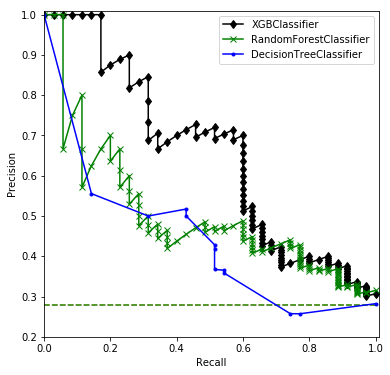

In [151]:
plt.figure(figsize = (6,6))
plot_prc(xgb_with_SMOTE, X_test, y_test, 'd' ,'k')
plot_prc(rf_with_SMOTE, X_test, y_test, 'x','g')
plot_prc(dt_with_SMOTE, X_test, y_test, '.' ,'b')

XGBClassifier: auc=0.653 ap=0.658
RandomForestClassifier: auc=0.643 ap=0.647
DecisionTreeClassifier: auc=0.514 ap=0.459


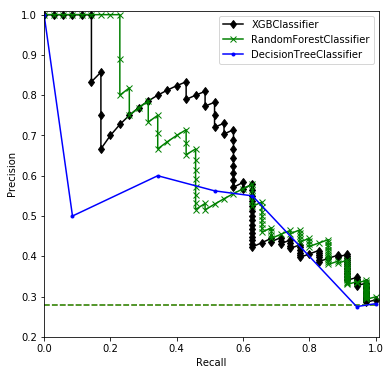

In [150]:
plt.figure(figsize = (6,6))
plot_prc(xgb_no_SMOTE, X_test, y_test, 'd' ,'k')
plot_prc(rf_no_SMOTE, X_test, y_test, 'x','g')
plot_prc(dt_no_SMOTE, X_test, y_test, '.' ,'b')

In [152]:
# confusion_matrix
def c_m(estimator, X_test, y_test):
    y_preds = estimator.predict(X_test)
    clf = str(estimator).split(',')[0].split('(')[0]
    print clf
    return confusion_matrix(y_test, y_preds)

In [153]:
print c_m(xgb_with_SMOTE, X_test, y_test)
print c_m(dt_with_SMOTE, X_test, y_test)
print c_m(rf_with_SMOTE, X_test, y_test)

XGBClassifier
[[81  8]
 [15 20]]
DecisionTreeClassifier
[[64 25]
 [17 18]]
RandomForestClassifier
[[68 21]
 [17 18]]


In [154]:
print c_m(xgb_no_SMOTE, X_test, y_test)
print c_m(dt_no_SMOTE, X_test, y_test)
print c_m(rf_no_SMOTE, X_test, y_test)

XGBClassifier
[[77 12]
 [15 20]]
DecisionTreeClassifier
[[75 14]
 [17 18]]
RandomForestClassifier
[[83  6]
 [21 14]]


In [39]:
import shap

In [52]:
# refernce:https://slundberg.github.io/shap/notebooks/NHANES%20I%20Survival%20Model.html

In [40]:
# load JS visualization code to notebook
shap.initjs()


In [41]:
# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
explainer = shap.TreeExplainer(xgb_no_SMOTE)
shap_values = explainer.shap_values(X_train_val)

# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

In [42]:
# visualize the training set predictions
shap.force_plot(explainer.expected_value, shap_values, X_train_val)

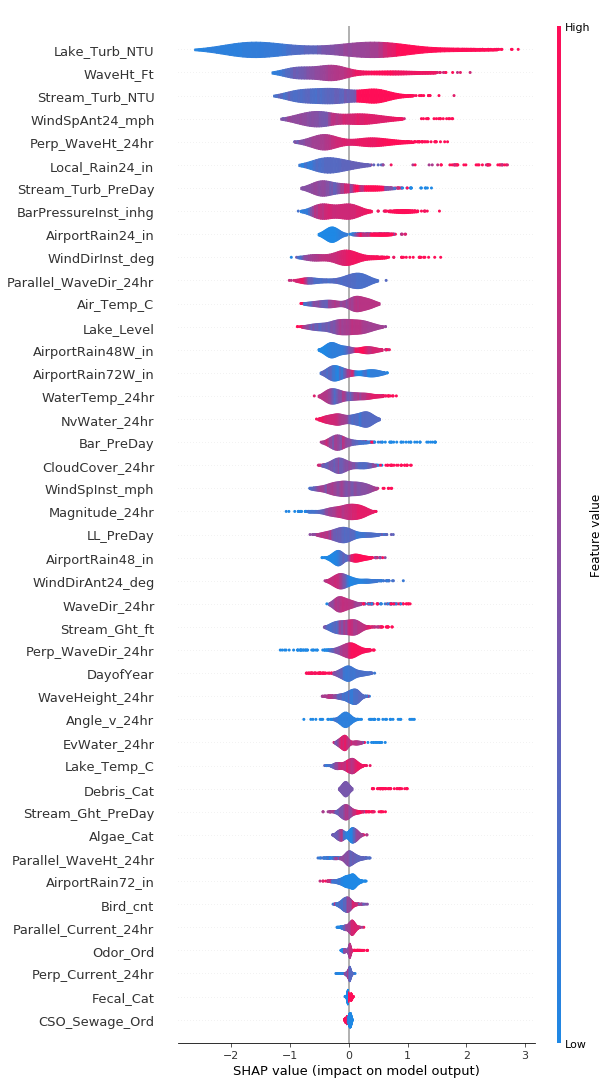

In [51]:
shap.summary_plot(shap_values, X_train_val, max_display=43, plot_type="violin")

In [45]:
shap_interaction_values = explainer.shap_interaction_values(X_train_val.iloc[:,:])

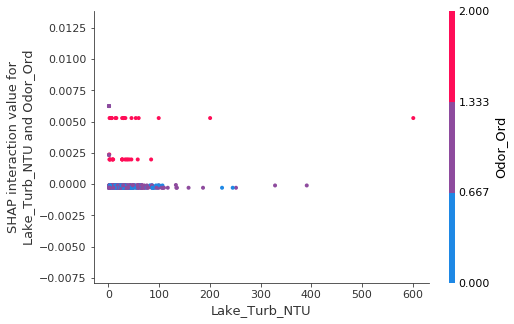

In [48]:
shap.dependence_plot(
    ("Lake_Turb_NTU", "Odor_Ord"),
    shap_interaction_values, X_train_val.iloc[:,:],
    display_features=X_train_val.iloc[:,:]
)